## Import ##

In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from model_profiler import model_profiler
from pathlib import Path
import json
import pandas as pd

batch_size = 90
epoch_size = 2500
test_len = 8
conv_factor = 8
dense_base = 64

In [2]:
def flatten(l):
    return [item for sublist in l for item in sublist]


def get_txt_data(path: Path) -> np.ndarray:
    with path.open("r", encoding="utf-8") as f:
        result: list = json.loads(f.readline())
        return np.array(flatten(result))


input_data: np.ndarray = np.load('data/train_input.npy')
output_data: np.ndarray = np.load('data/train_output.npy')
input_shape = input_data.shape[1:]
output_shape = output_data.shape[1:]

print('input shape')
print(input_shape)
print()
print('output shape')
print(output_shape)


def load_data():
    l = len(input_data)
    last = l - 1
    first = int(l-l/test_len)
    train_images = input_data[0:first]
    train_labels = output_data[0:first]

    test_images = input_data[first:last]
    test_labels = output_data[first:last]
    print('Train shape: {}'.format(train_images.shape))
    print('Test shape: {}'.format(test_images.shape))
    print('Test labels shape: {}'.format(test_labels.shape))

    return (train_images, train_labels), (test_images, test_labels)


input shape
(79, 53)

output shape
(82,)


In [3]:
(train_images, train_labels), (test_images, test_labels) = load_data()
input_shape = train_images.shape[1:3]
labels_shape = test_labels.shape[1]
print(np.prod(input_shape))


Train shape: (18061, 79, 53)
Test shape: (2580, 79, 53)
Test labels shape: (2580, 82)
4187


In [4]:

normalization = tf.keras.layers.Normalization(axis=None)
normalization.adapt([0,255.0])

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(input_shape))
model.add(normalization)
model.add(tf.keras.layers.Conv1D(4 * conv_factor, 32, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.Conv1D(4 * conv_factor * 2,6, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(dense_base * conv_factor, 'relu'))
model.add(tf.keras.layers.Dense(dense_base * conv_factor, 'relu'))
model.add(tf.keras.layers.Dense(labels_shape))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 79, 53)           3         
 n)                                                              
                                                                 
 conv1d (Conv1D)             (None, 48, 32)            54304     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 19, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 9, 64)            0         
 1D)                                                             
                                                        

In [5]:
# profile = model_profiler(model, batch_size)

# print(profile)


In [6]:
model.compile(optimizer='adam',
              loss="mae",)

history = model.fit(
    train_images, train_labels,
    epochs=epoch_size,
    batch_size=batch_size,
    validation_data=(test_images, test_labels)
)


Epoch 1/2500
201/201 [==============================] - 5s 4ms/step - loss: 134.4098 - val_loss: 111.1903
Epoch 2/2500
201/201 [==============================] - 1s 3ms/step - loss: 108.5585 - val_loss: 104.0142
Epoch 3/2500
201/201 [==============================] - 1s 3ms/step - loss: 93.6522 - val_loss: 88.7211
Epoch 4/2500
201/201 [==============================] - 1s 3ms/step - loss: 81.9254 - val_loss: 78.8986
Epoch 5/2500
201/201 [==============================] - 1s 3ms/step - loss: 75.6906 - val_loss: 75.3190
Epoch 6/2500
201/201 [==============================] - 1s 3ms/step - loss: 71.9704 - val_loss: 73.4233
Epoch 7/2500
201/201 [==============================] - 1s 3ms/step - loss: 68.5311 - val_loss: 67.8646
Epoch 8/2500
201/201 [==============================] - 1s 3ms/step - loss: 65.5187 - val_loss: 65.9167
Epoch 9/2500
201/201 [==============================] - 1s 3ms/step - loss: 62.7521 - val_loss: 63.4445
Epoch 10/2500
201/201 [==============================] - 1s 

In [7]:
history: dict = history.history
loss = history['loss']
val_loss = history['val_loss']
l = int(len(loss) / 10)
history['loss'] = loss[l:]
history['val_loss'] = val_loss[l:]


{'loss': [5.734358310699463, 5.9687628746032715, 5.946781635284424, 5.995620250701904, 6.201939582824707, 6.018238067626953, 5.930852890014648, 6.010906219482422, 6.59189510345459, 6.20781135559082, 5.61176061630249, 6.368113040924072, 5.690041542053223, 6.004947662353516, 5.819002628326416, 5.963945388793945, 5.771535396575928, 6.592287540435791, 6.003543376922607, 5.750421524047852, 5.5868144035339355, 5.7346577644348145, 5.614777088165283, 5.604424953460693, 5.538725852966309, 5.910946369171143, 5.921643257141113, 5.580680847167969, 5.624049186706543, 5.567918300628662, 5.552240371704102, 6.132391929626465, 5.689221382141113, 5.443641185760498, 5.6498637199401855, 5.7505011558532715, 5.383169651031494, 5.806023597717285, 5.915694713592529, 5.5573506355285645, 5.7686567306518555, 5.347788333892822, 5.943798065185547, 5.319010257720947, 5.407230854034424, 5.384062767028809, 5.924293041229248, 5.4653706550598145, 5.31810188293457, 5.5174455642700195, 5.604647159576416, 5.28501653671264

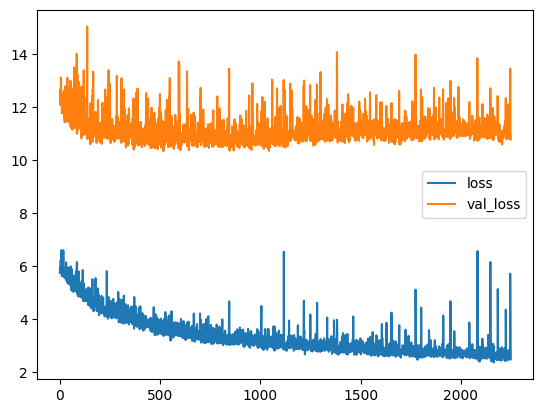

In [8]:

print(history)
history_df = pd.DataFrame(history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# plt.plot(history.history['accuracy'], label='accuracy')
# plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.ylim([0.5, 1])
# plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)


In [9]:
# print(test_acc)

# cuda.select_device(0)
# cuda.close()


In [10]:
model.save('out')

INFO:tensorflow:Assets written to: out\assets


INFO:tensorflow:Assets written to: out\assets
